# DAT257x: Reinforcement Learning Explained

## Lab 2: Bandits

### Exercise 2.3: UCB

In [29]:
import numpy as np
import sys

if "../" not in sys.path:
    sys.path.append("../") 

from lib.envs.bandit import BanditEnv
from lib.simulation import Experiment

In [30]:
#Policy interface
class Policy:
    #num_actions: (int) Number of arms [indexed by 0 ... num_actions-1]
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    def act(self):
        pass
        
    def feedback(self, action, reward):
        pass

In [31]:
#Greedy policy
class Greedy(Policy):
    def __init__(self, num_actions):
        Policy.__init__(self, num_actions)
        self.name = "Greedy"
        self.total_rewards = np.zeros(num_actions, dtype = np.longdouble)
        self.total_counts = np.zeros(num_actions, dtype = np.longdouble)
    
    def act(self):
        current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
        current_averages[self.total_counts <= 0] = 0.5      #Correctly handles Bernoulli rewards; over-estimates otherwise
        current_action = np.argmax(current_averages)
        return current_action
        
    def feedback(self, action, reward):
        self.total_rewards[action] += reward
        self.total_counts[action] += 1

In [32]:
#Epsilon Greedy policy
class EpsilonGreedy(Greedy):
    def __init__(self, num_actions, epsilon):
        Greedy.__init__(self, num_actions)
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
            
        self.epsilon = epsilon
        self.name = "Epsilon Greedy"
    
    def act(self):
        choice = None
        if self.epsilon == 0:
            choice = 0
        elif self.epsilon == 1:
            choice = 1
        else:
            choice = np.random.binomial(1, self.epsilon)
            
        if choice == 1:
            return np.random.choice(self.num_actions)
        else:
            current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
            current_averages[self.total_counts <= 0] = 0.5  #Correctly handles Bernoulli rewards; over-estimates otherwise
            current_action = np.argmax(current_averages)
            return current_action
        

Now let's implement a UCB algorithm. 



In [33]:
#UCB policy
class UCB(Greedy):
    def __init__(self, num_actions):
        Greedy.__init__(self, num_actions)
        self.name = "UCB"
        self.round = 0
        
    def act(self):
        current_action = None
        self.round += 1
        if self.round <= self.num_actions:
            """The first k rounds, where k is the number of arms/actions, play each arm/action once"""
            current_action = self.round - 1
        else:
            """At round t, play the arms with maximum average and exploration bonus"""
            current_averages = np.divide(self.total_rewards, self.total_counts)
            current_ucb = current_averages + np.sqrt(np.divide(2 * np.log(self.round),self.total_counts))
            current_action = np.argmax(current_ucb)
        return current_action

Now let's prepare the simulation. 

In [34]:
evaluation_seed = 1290
num_actions = 10
trials = 10000
distribution = "bernoulli"


What do you think the regret graph would look like?

Distribution: normal (array([-0.85664773, -1.38134542,  0.24473768, -2.02825359, -0.00952477,
       -1.58257695, -0.12190786,  0.10229011,  0.47264353, -1.14416057]), array([0.44671157, 0.7358406 , 0.09895759, 0.3168743 , 0.4572893 ,
       0.35473417, 0.30362426, 0.07378078, 0.49080171, 0.95729536]))
Optimal arm: 8
--------------------------------------------------
Policy: UCB 
Average Reward: 0.4475721502471028 
Average Regret: 0.02160043817180788
Arm pulls: [1.100e+01 5.000e+00 2.380e+02 4.000e+00 7.700e+01 4.000e+00 4.200e+01
 1.030e+02 9.504e+03 1.200e+01]


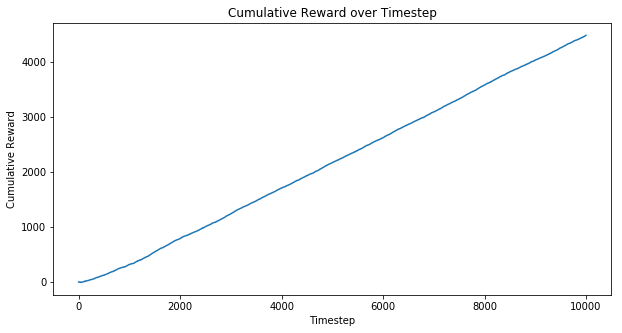

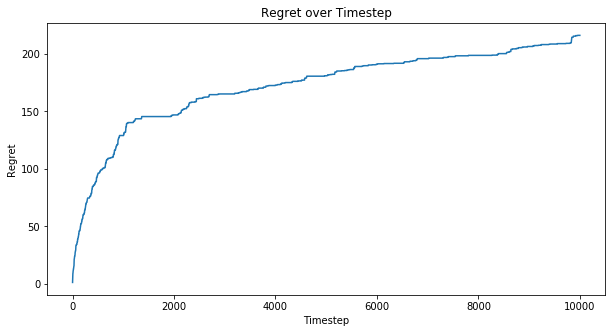

In [35]:
env = BanditEnv(num_actions, distribution, evaluation_seed)
agent = UCB(num_actions)
experiment = Experiment(env, agent)
experiment.run_bandit(trials)